<div id="singlestore-header" style="display: flex; background-color: rgba(210, 255, 153, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/chart-network.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">How to Build LLM Apps that can See Hear Speak</h1>
    </div>
</div>

<div class="alert alert-block alert-info">
    <b class="fa fa-solid fa-info-circle"></b>
    <div>
        <p><b>Note</b></p>
        <p>This tutorial is meant for Standard & Premium Workspaces. You can't run this with a Free Starter Workspace due to restrictions on Storage. Create a Workspace using +group in the left nav & select Standard for this notebook. Gallery notebooks tagged with "Starter" are suitable to run on a Free Starter Workspace </p>
    </div>
</div>

<a name="architecture"></a>

# Demo Architecture
![SingleStore LLM App](https://images.contentstack.io/v3/assets/bltac01ee6daa3a1e14/bltb25c874a947f70f9/65aa3b99573161fd44cc7b7d/singlestore-llm-app.png)

<a name="contents"></a>
# Contents
- [Demo Architecture](#architecture)
- [Step 1: SingleStore DDLs](#ddl)
- [Step 2: Packages and imports](#imports)
- [Step 3: Ingest from data sources](#ingest)
- [Step 4: Connect SingleStore to Open AI's LLM with Langchain](#connect_s2)
- [Step 5: Add Voice Recognition and Speech](#speech)
- [Step 6: Tying it together with Image data](#image)
- [Conclusion](#conclusion)

<a name="ddl"></a>
- [Back to Contents](#contents)
## Setup SingleStore DDLs

Create and use the database llm_webinar

In [1]:
%%sql
DROP DATABASE IF EXISTS llm_webinar;
CREATE DATABASE llm_webinar;

++
||
++
++

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> Make sure to select a database from the drop-down menu at the top of this notebook. It updates the <tt>connection_url</tt>  to connect to that database.</p>
    </div>
</div>

Create tables

In [2]:
%%sql
CREATE TABLE `stockTable` (
    `ticker` varchar(20) CHARACTER SET utf8 COLLATE utf8_general_ci DEFAULT NULL,
    `created_at` datetime DEFAULT NULL,
    `open` float DEFAULT NULL,
    `high` float DEFAULT NULL,
    `low` float DEFAULT NULL,
    `close` float DEFAULT NULL,
    `volume` int(11) DEFAULT NULL,
    SORT KEY (ticker, created_at desc),
    SHARD KEY (ticker)
);

CREATE TABLE newsSentiment (
    title TEXT CHARACTER SET utf8mb4,
    url TEXT,
    time_published DATETIME,
    authors TEXT,
    summary TEXT CHARACTER SET utf8mb4,
    banner_image TEXT,
    source TEXT,
    category_within_source TEXT,
    source_domain TEXT,
    topic TEXT,
    topic_relevance_score TEXT,
    overall_sentiment_score REAL,
    overall_sentiment_label TEXT,
    `ticker` varchar(20) CHARACTER SET utf8 COLLATE utf8_general_ci DEFAULT NULL,
    ticker_relevance_score DECIMAL(10, 6),
    ticker_sentiment_score DECIMAL(10, 6),
    ticker_sentiment_label TEXT,
    SORT KEY (`ticker`,`time_published` DESC),
    SHARD KEY `__SHARDKEY` (`ticker`,`time_published` DESC),
    KEY(ticker) USING HASH,
    KEY(authors) USING HASH,
    KEY(source) USING HASH,
    KEY(overall_sentiment_label) USING HASH,
    KEY(ticker_sentiment_label) USING HASH
);

CREATE ROWSTORE REFERENCE TABLE companyInfo (
    ticker VARCHAR(10) PRIMARY KEY,
    AssetType VARCHAR(50),
    Name VARCHAR(100),
    Description TEXT,
    CIK VARCHAR(10),
    Exchange VARCHAR(10),
    Currency VARCHAR(10),
    Country VARCHAR(50),
    Sector VARCHAR(50),
    Industry VARCHAR(250),
    Address VARCHAR(100),
    FiscalYearEnd VARCHAR(20),
    LatestQuarter DATE,
    MarketCapitalization BIGINT,
    EBITDA BIGINT,
    PERatio DECIMAL(10, 2),
    PEGRatio DECIMAL(10, 3),
    BookValue DECIMAL(10, 2),
    DividendPerShare DECIMAL(10, 2),
    DividendYield DECIMAL(10, 4),
    EPS DECIMAL(10, 2),
    RevenuePerShareTTM DECIMAL(10, 2),
    ProfitMargin DECIMAL(10, 4),
    OperatingMarginTTM DECIMAL(10, 4),
    ReturnOnAssetsTTM DECIMAL(10, 4),
    ReturnOnEquityTTM DECIMAL(10, 4),
    RevenueTTM BIGINT,
    GrossProfitTTM BIGINT,
    DilutedEPSTTM DECIMAL(10, 2),
    QuarterlyEarningsGrowthYOY DECIMAL(10, 3),
    QuarterlyRevenueGrowthYOY DECIMAL(10, 3),
    AnalystTargetPrice DECIMAL(10, 2),
    TrailingPE DECIMAL(10, 2),
    ForwardPE DECIMAL(10, 2),
    PriceToSalesRatioTTM DECIMAL(10, 3),
    PriceToBookRatio DECIMAL(10, 2),
    EVToRevenue DECIMAL(10, 3),
    EVToEBITDA DECIMAL(10, 2),
    Beta DECIMAL(10, 3),
    52WeekHigh DECIMAL(10, 2),
    52WeekLow DECIMAL(10, 2),
    50DayMovingAverage DECIMAL(10, 2),
    200DayMovingAverage DECIMAL(10, 2),
    SharesOutstanding BIGINT,
    DividendDate DATE,
    ExDividendDate DATE
);

CREATE TABLE `embeddings` (
    `id` bigint(11) NOT NULL AUTO_INCREMENT,
    `category` varchar(255) CHARACTER SET utf8 COLLATE utf8_general_ci DEFAULT NULL,
    `question` longtext CHARACTER SET utf8 COLLATE utf8_general_ci,
    `question_embedding` longblob,
    `answer` longtext CHARACTER SET utf8 COLLATE utf8_general_ci,
    `answer_embedding` longblob,
    `created_at` datetime DEFAULT NULL,
    UNIQUE KEY `PRIMARY` (`id`) USING HASH,
    SHARD KEY `__SHARDKEY` (`id`),
    KEY `category` (`category`) USING HASH,
    SORT KEY `__UNORDERED` (`created_at` DESC)
);

++
||
++
++

In [3]:
%%sql
SHOW TABLES;

Tables_in_llm_webinar
companyInfo
embeddings
newsSentiment
stockTable


<a name="imports"></a>
- [Back to Contents](#contents)
## Install packages and imports

In [4]:
%pip install elevenlabs==0.2.27 openai==1.32.0 matplotlib scipy scikit-learn langchain==0.2.12 langchain-openai==0.1.20 langchain-community==0.2.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 966.1 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 20.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 60.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 34.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 48.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 12.0 MB

In [5]:
import datetime
import getpass
import numpy as np
import openai
import requests
import singlestoredb as s2
import time
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from langchain.sql_database import SQLDatabase
from langchain_openai import OpenAI as LangchainOpenAI
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.agents import create_sql_agent

### Set API keys

In [6]:
alpha_vantage_apikey = getpass.getpass("enter alphavantage apikey here")
openai_apikey = getpass.getpass("enter openai apikey here")
elevenlabs_apikey = getpass.getpass("enter elevenlabs apikey here")

enter alphavantage apikey here ········
enter openai apikey here ········
enter elevenlabs apikey here ········


In [7]:
from openai import OpenAI

client = OpenAI(api_key=openai_apikey)

def get_embeddings(inputs: list[str], model: str = 'text-embedding-ada-002') -> list[str]:
    """Return list of embeddings."""
    return [x.embedding for x in client.embeddings.create(input=inputs, model=model).data]

<a name="ingest"></a>
- [Back to Contents](#contents)
## Ingest from data sources

### Bring past two months of stock data

In [8]:
# set up connection to SingleStore and the ticker list
s2_conn = s2.connect(connection_url)
ticker_list = ['TSLA', 'AMZN', 'PLTR']

In [9]:
from datetime import datetime

def get_past_months(num_months):
    today = datetime.today()
    months = []

    for months_ago in range(0, num_months):
        target_date = today - relativedelta(months=months_ago)
        months.append(target_date.strftime('%Y-%m'))

    return months

num_months = 2  # Number of months
year_month_list = get_past_months(num_months)
print(year_month_list)

# pull intraday data for each stock and write to SingleStore
for ticker in ticker_list:
    print(ticker)
    data_list = []
    for year_month in year_month_list:
        print(year_month)

        intraday_price_url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={}&interval=5min&month={}&outputsize=full&apikey={}".format(ticker, year_month, alpha_vantage_apikey)
        r = requests.get(intraday_price_url)

        try:
            data = r.json()['Time Series (5min)']
        except:
            time.sleep(1) # required to not hit API limits
            continue

        for key in data:
            document = data[key]
            document['datetime'] = key
            document['ticker'] = ticker

            document['open'] = document['1. open']
            document['high'] = document['2. high']
            document['low'] = document['3. low']
            document['close'] = document['4. close']
            document['volume'] = document['5. volume']

            document['open'] = float(document['open'])
            document['high'] = float(document['high'])
            document['low'] = float(document['low'])
            document['close'] = float(document['close'])
            document['volume'] = int(document['volume'])


            del document['1. open']
            del document['2. high']
            del document['3. low']
            del document['4. close']
            del document['5. volume']

            data_list += [document]

            # Inside your loop, create the params dictionary with the correct values
            params = {
                'datetime': document['datetime'],
                'ticker': ticker,
                'open': document['open'],
                'high': document['high'],
                'low': document['low'],
                'close': document['close'],
                'volume': document['volume']
            }

            # Construct and execute the SQL statement
            table_name = 'stockTable'
            stmt = f"INSERT INTO {table_name} (created_at, ticker, open, high, low, close, volume) VALUES (%(datetime)s, %(ticker)s, %(open)s, %(high)s, %(low)s, %(close)s, %(volume)s)"

            with s2_conn.cursor() as cur:
                cur.execute(stmt, params)
        # time.sleep(1) # required to not hit API limits

['2024-08', '2024-07']
TSLA
2024-08
2024-07
AMZN
2024-08
2024-07
PLTR
2024-08
2024-07


In [10]:
%%sql
select count(*) from stockTable

count(*)
14869


## Bring in Company data

In [11]:
def float_or_none(x):
    if x is None or x == 'None':
        return None
    return float(x)

# pull intraday data for each stock and write to SingleStore
for ticker in ticker_list:
    print(ticker)
    data_list = []
    # for year_month in year_month_list:

    company_overview = "https://www.alphavantage.co/query?function=OVERVIEW&symbol={}&outputsize=full&apikey={}".format(ticker, alpha_vantage_apikey)
    r = requests.get(company_overview)

    try:
        data = r.json()
    except:
        time.sleep(3) # required to not hit API limits
        continue

    if 'CIK' not in data:
        raise RuntimeError(str(data))

    data['CIK'] = int(data['CIK'])
    data['MarketCapitalization']= float_or_none(data['MarketCapitalization'])
    # Assuming data['EBITDA'] is a string containing 'None'
    ebitda_str = data['EBITDA']
    if ebitda_str.lower() == 'none':
        # Handle the case where EBITDA is 'None', for example, you can set it to 0
        data['EBITDA'] = 0.0
    else:
        # Convert the EBITDA string to a float
        data['EBITDA'] = float_or_none(ebitda_str)

    PERatio_flt = data['PERatio']
    if PERatio_flt.lower() == 'none':
        # Handle the case where EVToRevenue is '-'
        data['PERatio'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['PERatio'] = float_or_none(PERatio_flt)

    data['PEGRatio']= float_or_none(data['PEGRatio'])
    data['BookValue']= float_or_none(data['BookValue'])
    data['DividendPerShare']= float_or_none(data['DividendPerShare'])
    data['DividendYield']= float_or_none(data['DividendYield'])
    data['EPS']= float_or_none(data['EPS'])
    data['RevenuePerShareTTM']= float_or_none(data['RevenuePerShareTTM'])
    data['ProfitMargin']= float_or_none(data['ProfitMargin'])
    data['OperatingMarginTTM']= float_or_none(data['OperatingMarginTTM'])
    data['ReturnOnAssetsTTM']= float_or_none(data['ReturnOnAssetsTTM'])
    data['ReturnOnEquityTTM']= float_or_none(data['ReturnOnEquityTTM'])
    data['RevenueTTM']= int(data['RevenueTTM'])
    data['GrossProfitTTM']= int(data['GrossProfitTTM'])
    data['DilutedEPSTTM']= float_or_none(data['DilutedEPSTTM'])
    data['QuarterlyEarningsGrowthYOY']= float_or_none(data['QuarterlyEarningsGrowthYOY'])
    data['QuarterlyRevenueGrowthYOY']= float_or_none(data['QuarterlyRevenueGrowthYOY'])
    data['AnalystTargetPrice']= float_or_none(data['AnalystTargetPrice'])
    # Assuming data['TrailingPE'] is a string containing '-'
    trailing_pe_str = data['TrailingPE']
    if trailing_pe_str == '-':
        # Handle the case where TrailingPE is '-'
        data['TrailingPE'] = 0.0  # You can use any default value that makes sense
    else:
        try:
            # Attempt to convert the TrailingPE string to a float
            data['TrailingPE'] = float_or_none(trailing_pe_str)
        except ValueError:
            # Handle the case where the conversion fails (e.g., if it contains invalid characters)
            data['TrailingPE'] = 0.0  # Set to a default value or handle as needed

    data['ForwardPE']= float_or_none(data['ForwardPE'])
    data['PriceToSalesRatioTTM']= float_or_none(data['PriceToSalesRatioTTM'])
    # Assuming data['EVToRevenue'] is a string containing '-'
    PriceToBookRatio_flt = data['PriceToBookRatio']
    if PriceToBookRatio_flt == '-':
        # Handle the case where EVToRevenue is '-'
        data['PriceToBookRatio'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['PriceToBookRatio'] = float_or_none(PriceToBookRatio_flt)

    # Assuming data['EVToRevenue'] is a string containing '-'
    ev_to_revenue_str = data['EVToRevenue']
    if ev_to_revenue_str == '-':
        # Handle the case where EVToRevenue is '-'
        data['EVToRevenue'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['EVToRevenue'] = float_or_none(ev_to_revenue_str)

    # data['EVToEBITDA']= float(data['EVToEBITDA'])
    # Assuming data['EVToRevenue'] is a string containing '-'
    ev_to_EBITDA_str = data['EVToEBITDA']
    if ev_to_revenue_str == '-':
        # Handle the case where EVToRevenue is '-'
        data['EVToEBITDA'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['EVToEBITDA'] = float_or_none(ev_to_EBITDA_str)

    data['Beta']= float_or_none(data['Beta'])
    data['52WeekHigh']= float_or_none(data['52WeekHigh'])
    data['52WeekLow']= float_or_none(data['52WeekLow'])
    data['50DayMovingAverage']= float_or_none(data['50DayMovingAverage'])
    data['200DayMovingAverage']= float_or_none(data['200DayMovingAverage'])
    data['SharesOutstanding']= int(data['SharesOutstanding'])
    # description_embedding = [np.array(x, '<f4') for x in get_embeddings(data["Description"], model=model)]
    dividend_date_str = data['DividendDate']
    if dividend_date_str.lower() == 'none':
        # Handle the case where EBITDA is 'None', for example, you can set it to 0
        data['DividendDate'] = '9999-12-31'
    else:
        # Convert the EBITDA string to a float
        data['DividendDate'] = str(dividend_date_str)

    exdividend_date_str = data['ExDividendDate']
    if exdividend_date_str.lower() == 'none':
        # Handle the case where EBITDA is 'None', for example, you can set it to 0
        data['ExDividendDate'] = '9999-12-31'
    else:
        # Convert the EBITDA string to a float
        data['ExDividendDate'] = str(exdividend_date_str)

    data_list += [data]

    # Inside your loop, create the params dictionary with the correct values
    params = {
                "Symbol": data["Symbol"],
                "AssetType": data["AssetType"],
                "Name": data["Name"],
                "Description": data["Description"],
                "CIK": data["CIK"],
                "Exchange": data["Exchange"],
                "Currency": data["Currency"],
                "Country": data["Country"],
                "Sector": data["Sector"],
                "Industry": data["Industry"],
                "Address": data["Address"],
                "FiscalYearEnd": data["FiscalYearEnd"],
                "LatestQuarter": data["LatestQuarter"],
                "MarketCapitalization": data["MarketCapitalization"],
                "EBITDA": data["EBITDA"],
                "PERatio": data["PERatio"],
                "PEGRatio": data["PEGRatio"],
                "BookValue": data["BookValue"],
                "DividendPerShare": data["DividendPerShare"],
                "DividendYield": data["DividendYield"],
                "EPS": data["EPS"],
                "RevenuePerShareTTM": data["RevenuePerShareTTM"],
                "ProfitMargin": data["ProfitMargin"],
                "OperatingMarginTTM": data["OperatingMarginTTM"],
                "ReturnOnAssetsTTM": data["ReturnOnAssetsTTM"],
                "ReturnOnEquityTTM": data["ReturnOnEquityTTM"],
                "RevenueTTM": data["RevenueTTM"],
                "GrossProfitTTM": data["GrossProfitTTM"],
                "DilutedEPSTTM": data["DilutedEPSTTM"],
                "QuarterlyEarningsGrowthYOY": data["QuarterlyEarningsGrowthYOY"],
                "QuarterlyRevenueGrowthYOY": data["QuarterlyRevenueGrowthYOY"],
                "AnalystTargetPrice": data["AnalystTargetPrice"],
                "TrailingPE": data["TrailingPE"],
                "ForwardPE": data["ForwardPE"],
                "PriceToSalesRatioTTM": data["PriceToSalesRatioTTM"],
                "PriceToBookRatio": data["PriceToBookRatio"],
                "EVToRevenue": data["EVToRevenue"],
                "EVToEBITDA": data["EVToEBITDA"],
                "Beta": data["Beta"],
                "52WeekHigh": data["52WeekHigh"],
                "52WeekLow": data["52WeekLow"],
                "50DayMovingAverage": data["50DayMovingAverage"],
                "200DayMovingAverage": data["200DayMovingAverage"],
                "SharesOutstanding": data["SharesOutstanding"],
                "DividendDate": data["DividendDate"],
                "ExDividendDate": data["ExDividendDate"]
    }

     # Construct and execute the SQL statement
    table_name = 'companyInfo'
    stmt = f"INSERT INTO {table_name} (ticker, AssetType, Name, Description, CIK, Exchange, Currency, Country, Sector, Industry, Address, FiscalYearEnd, LatestQuarter, MarketCapitalization, EBITDA, PERatio, PEGRatio, BookValue, DividendPerShare, DividendYield, EPS, RevenuePerShareTTM, ProfitMargin, OperatingMarginTTM, ReturnOnAssetsTTM, ReturnOnEquityTTM, RevenueTTM, GrossProfitTTM, DilutedEPSTTM, QuarterlyEarningsGrowthYOY, QuarterlyRevenueGrowthYOY, AnalystTargetPrice, TrailingPE, ForwardPE, PriceToSalesRatioTTM, PriceToBookRatio, EVToRevenue, EVToEBITDA, Beta, 52WeekHigh, 52WeekLow, 50DayMovingAverage, 200DayMovingAverage, SharesOutstanding, DividendDate, ExDividendDate) VALUES (%(Symbol)s, %(AssetType)s, %(Name)s, %(Description)s, %(CIK)s, %(Exchange)s, %(Currency)s, %(Country)s, %(Sector)s, %(Industry)s, %(Address)s, %(FiscalYearEnd)s, %(LatestQuarter)s, %(MarketCapitalization)s, %(EBITDA)s, %(PERatio)s, %(PEGRatio)s, %(BookValue)s, %(DividendPerShare)s, %(DividendYield)s, %(EPS)s, %(RevenuePerShareTTM)s, %(ProfitMargin)s, %(OperatingMarginTTM)s, %(ReturnOnAssetsTTM)s, %(ReturnOnEquityTTM)s, %(RevenueTTM)s, %(GrossProfitTTM)s, %(DilutedEPSTTM)s, %(QuarterlyEarningsGrowthYOY)s, %(QuarterlyRevenueGrowthYOY)s, %(AnalystTargetPrice)s, %(TrailingPE)s, %(ForwardPE)s, %(PriceToSalesRatioTTM)s, %(PriceToBookRatio)s, %(EVToRevenue)s, %(EVToEBITDA)s, %(Beta)s, %(52WeekHigh)s, %(52WeekLow)s, %(50DayMovingAverage)s, %(200DayMovingAverage)s, %(SharesOutstanding)s, %(DividendDate)s, %(ExDividendDate)s)"

# Replace table_name with the actual table name you're using.
    with s2_conn.cursor() as cur:
        cur.execute(stmt, params)

TSLA
AMZN
PLTR


In [12]:
%%sql
select * from companyInfo limit 1

ticker,AssetType,Name,Description,CIK,Exchange,Currency,Country,Sector,Industry,Address,FiscalYearEnd,LatestQuarter,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,AnalystTargetPrice,TrailingPE,ForwardPE,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
AMZN,Common Stock,Amazon.com Inc,"Amazon.com, Inc. is an American multinational technology company which focuses on e-commerce, cloud computing, digital streaming, and artificial intelligence. It is one of the Big Five companies in the U.S. information technology industry, along with Google, Apple, Microsoft, and Facebook. The company has been referred to as one of the most influential economic and cultural forces in the world, as well as the world's most valuable brand.",1018724,NASDAQ,USD,USA,TRADE & SERVICES,RETAIL-CATALOG & MAIL-ORDER HOUSES,"410 TERRY AVENUE NORTH, SEATTLE, WA, US",December,2024-03-31,1690001474000,104049000000,38.34,1.784,22.54,None,None,4.20,58.22,0.0735,0.0992,0.0658,0.2190,604333998000,225152000000,4.20,0.938,0.101,221.87,38.34,35.97,2.796,7.45,2.987,16.95,1.155,201.20,118.35,186.35,168.68,10495600000,9999-12-31,9999-12-31


## Bring in news sentiment

In [13]:
import datetime

# pull intraday data for each stock and write to Mongo
for ticker in ticker_list:
    print(ticker)
    data_list = []

    for i in year_month_list:
        date_object = datetime.datetime.strptime(i, '%Y-%m')
        print(date_object)
        output_date = date_object.strftime('%Y%m%d') + "T0000"

        # Get the next month from the 'date_object'
        previous_month_date = date_object + relativedelta(months=-1)
        previous_month_date = previous_month_date.strftime('%Y%m%d') + "T0000"

        # Update 'date_object' for the next iteration
        date_object = previous_month_date

        # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
        news_and_sentiment = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={}&time_from={}&time_to={}&limit=1000&outputsize=full&apikey={}'.format(ticker, previous_month_date, output_date, alpha_vantage_apikey)
        r = requests.get(news_and_sentiment)

        try:
            data = r.json()
            data = data["feed"]
        except:
            time.sleep(2) # required to not hit API limits
            continue

        for item in data:
            item['title'] = str(item['title'])
            item['url'] = str(item['url'])
            item['time_published'] = datetime.datetime.strptime(str(item['time_published']), "%Y%m%dT%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

            if item['authors']:
                # Check if the 'authors' list is not empty
                authors_str = str(item['authors'][0])
            else:
                # Handle the case where 'authors' is empty
                authors_str = "No authors available"

            item['authors'] = authors_str

            item['summary'] = str(item['summary'])
            item['banner_image'] = str(item['banner_image'])
            item['source'] = str(item['source'])
            item['category_within_source'] = str(item['category_within_source'])
            item['source_domain'] = str(item['source_domain'])
            item['topic'] = str(item['topics'][0]["topic"])
            item['topic_relevance_score'] = float(item['topics'][0]['relevance_score'])
            item['overall_sentiment_score'] = float(item['overall_sentiment_score'])
            item['overall_sentiment_label'] = str(item['overall_sentiment_label'])
            item['ticker'] = str(item['ticker_sentiment'][0]['ticker'])
            item['ticker_relevance_score'] = float(item['ticker_sentiment'][0]['relevance_score'])
            item['ticker_sentiment_score'] = float(item['ticker_sentiment'][0]['ticker_sentiment_score'])
            item['ticker_sentiment_label'] = str(item['ticker_sentiment'][0]['ticker_sentiment_label'])

            params= {
                "title": item["title"],
                "url": item["url"],
                "time_published": item["time_published"],
                "authors": item["authors"],
                "summary": item["summary"],
                "banner_image": item["banner_image"],
                "source": item["source"],
                "category_within_source": item["category_within_source"],
                "source_domain": item["source_domain"],
                "topic": item["topic"],
                "topic_relevance_score": item['topic_relevance_score'],
                'overall_sentiment_score': item['overall_sentiment_score'],
                'overall_sentiment_label': item['overall_sentiment_label'],
                'ticker': item['ticker'],
                'ticker_relevance_score': item['ticker_relevance_score'],
                'ticker_sentiment_score': item['ticker_sentiment_score'],
                'ticker_sentiment_label': item['ticker_sentiment_label']
            }
            #print(params)

            # Construct and execute the SQL statement
            table_name = 'newsSentiment'
            stmt = f"INSERT INTO {table_name} (title, url, time_published, authors, summary, banner_image, source, category_within_source, source_domain, topic, topic_relevance_score, overall_sentiment_score, overall_sentiment_label, ticker, ticker_relevance_score, ticker_sentiment_score, ticker_sentiment_label) VALUES (%(title)s, %(url)s, %(time_published)s, %(authors)s, %(summary)s, %(banner_image)s, %(source)s, %(category_within_source)s, %(source_domain)s, %(topic)s, %(topic_relevance_score)s, %(overall_sentiment_score)s, %(overall_sentiment_label)s, %(ticker)s, %(ticker_relevance_score)s, %(ticker_sentiment_score)s, %(ticker_sentiment_label)s)"

            # Replace table_name with the actual table name you're using.

            with s2_conn.cursor() as cur:
                cur.execute(stmt, params)

TSLA
2024-08-01 00:00:00
2024-07-01 00:00:00
AMZN
2024-08-01 00:00:00
2024-07-01 00:00:00
PLTR
2024-08-01 00:00:00
2024-07-01 00:00:00


In [14]:
%%sql
SELECT count(*) Rows_in_newsSentiment FROM newsSentiment

Rows_in_newsSentiment
2359


<a name="connect_s2"></a>
- [Back to Demo Architecture](#architecture)
## Connect SingleStore to Open AI's LLM with Langchain

In [15]:
os.environ["OPENAI_API_KEY"] = openai_apikey
embedding_model = 'text-embedding-ada-002'
gpt_model = 'gpt-3.5-turbo-16k'

# Create the agent executor
db = SQLDatabase.from_uri(connection_url, include_tables=['embeddings', 'companyInfo', 'newsSentiment', 'stockTable'], sample_rows_in_table_info=2)
llm = LangchainOpenAI(openai_api_key=os.environ["OPENAI_API_KEY"], temperature=0, verbose=True)
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

agent_executor = create_sql_agent(
    llm=LangchainOpenAI(temperature=0),
    toolkit=toolkit,
    verbose=True,
    prefix= '''
    You are an agent designed to interact with a SQL database called SingleStore. This sometimes has Shard and Sort keys in the table schemas, which you can ignore.
    \nGiven an input question, create a syntactically correct MySQL query to run, then look at the results of the query and return the answer.
    \n If you are asked about similarity questions, you should use the DOT_PRODUCT function.

    \nHere are a few examples of how to use the DOT_PRODUCT function:
    \nExample 1:
    Q: how similar are the questions and answers?
    A: The query used to find this is:

        select question, answer, dot_product(question_embedding, answer_embedding) as similarity from embeddings;

    \nExample 2:
    Q: What are the most similar questions in the embeddings table, not including itself?
    A: The query used to find this answer is:

        SELECT q1.question as question1, q2.question as question2, DOT_PRODUCT(q1.question_embedding, q2.question_embedding) :> float as score
        FROM embeddings q1, embeddings q2
        WHERE question1 != question2
        ORDER BY score DESC LIMIT 5;

    \nExample 3:
    Q: In the embeddings table, which rows are from the chatbot?
    A: The query used to find this answer is:

        SELECT category, question, answer FROM embeddings
        WHERE category = 'chatbot';

    \nIf you are asked to describe the database, you should run the query SHOW TABLES
    \nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
    \n The question embeddings and answer embeddings are very long, so do not show them unless specifically asked to.
    \nYou can order the results by a relevant column to return the most interesting examples in the database.
    \nNever query for all the columns from a specific table, only ask for the relevant columns given the question.
    \nYou have access to tools for interacting with the database.\nOnly use the below tools.
    Only use the information returned by the below tools to construct your final answer.
    \nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again up to 3 times.
    \n\nDO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
    \n\nIf the question does not seem related to the database, just return "I don\'t know" as the answer.\n,

    ''',
    format_instructions='''Use the following format:\n
    \nQuestion: the input question you must answer
    \nThought: you should always think about what to do
    \nAction: the action to take, should be one of [{tool_names}]
    \nAction Input: the input to the action
    \nObservation: the result of the action
    \nThought: I now know the final answer
    \nFinal Answer: the final answer to the original input question
    \nSQL Query used to get the Answer: the final sql query used for the final answer'
    ''',
    top_k=3,
    max_iterations=5
)

### Create function that processes user question with a check in Semantic Cache Layer

In [16]:
table_name = 'embeddings'
similarity_threshold = .97

def process_user_question(question):
    print(f'\nQuestion asked: {question}')
    category = 'chatbot'

    # Get vector embedding from the original question and calculate the elapsed time
    start_time = time.time()
    question_embedding= [np.array(x, '<f4') for x in get_embeddings([question], model=embedding_model)]
    elapsed_time = (time.time() - start_time) * 1000
    print(f"Execution time for getting the question embedding: {elapsed_time:.2f} milliseconds")

    params = {
              'question_embedding': question_embedding,
            }

    # Check if embedding is similar to existing questions
    # If semantic score < similarity_threshold, then run the agent executor
    # Calculate elapsed time for this step

    stmt = f'select question, answer, dot_product( %(question_embedding)s, question_embedding) :> float as score from embeddings where category="chatbot" order by score desc limit 1;'


    with s2_conn.cursor() as cur:
        start_time = time.time()
        cur.execute(stmt, params)
        row = cur.fetchone()
        elapsed_time = (time.time() - start_time) * 1000
        print(f"Execution time for checking existing questions: {elapsed_time:.2f} milliseconds")

        try:
            question2, answer, score = row
            print(f"\nClosest Matching row:\nQuestion: {question2}\nAnswer: {answer}\nSimilarity Score: {score}")

            if score > similarity_threshold:
                print('Action to take: Using existing answer')
                return answer

            else:
                print('Action to take: Running agent_executor')
                start_time = time.time()
                answer2 = agent_executor.run(question)
                elapsed_time = (time.time() - start_time) * 1000
                print(f"agent_executor execution time: {elapsed_time:.2f} milliseconds")

                # Get current time
                created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                # Get the answer embedding and calculate the elapsed time
                start_time = time.time()
                answer_embedding = [np.array(x, '<f4') for x in get_embeddings([answer2], model=embedding_model)]
                elapsed_time = (time.time() - start_time) * 1000
                print(f"Answer embeddings execution time: {elapsed_time:.2f} milliseconds")

                params = {'category': category, 'question': question,
                        'question_embedding': question_embedding,
                        'answer': answer2, 'answer_embedding': answer_embedding,
                        'created_at': created_at}

                # Send params details as a row into the SingleStoreDB embeddings table and calculate the elapsed time
                stmt = f"INSERT INTO {table_name} (category, question, question_embedding, answer, answer_embedding, created_at) VALUES (%(category)s, \n%(question)s, \n%(question_embedding)s, \n%(answer)s, \n%(answer_embedding)s, \n%(created_at)s)"
                start_time = time.time()

                with s2_conn.cursor() as cur:
                    cur.execute(stmt, params)

                elapsed_time = (time.time() - start_time) * 1000
                print(f"Insert to SingleStore execution time: {elapsed_time:.2f} milliseconds")

                return answer2

        # Handle known exceptions then run as normal
        except:
            print('No existing rows.  Running agent_executor')
            start_time = time.time()
            answer2 = agent_executor.run(question)
            elapsed_time = (time.time() - start_time) * 1000
            print(f"agent_executor execution time: {elapsed_time:.2f} milliseconds")

            created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # Record the start time
            start_time = time.time()

            answer_embedding = [np.array(x, '<f4') for x in get_embeddings([answer2], model=embedding_model)]

            # Calculate the elapsed time
            elapsed_time = (time.time() - start_time) * 1000
            print(f"Answer embeddings execution time: {elapsed_time:.2f} milliseconds")

            params = {'category': category, 'question': question,
                    'question_embedding': question_embedding,
                    'answer': answer2, 'answer_embedding': answer_embedding,
                    'created_at': created_at}

            # Send to SingleStoreDB
            stmt = f"INSERT INTO {table_name} (category, question, question_embedding, answer, answer_embedding, created_at) VALUES (%(category)s, \n%(question)s, \n%(question_embedding)s, \n%(answer)s, \n%(answer_embedding)s, \n%(created_at)s)"

            # Record the start time
            start_time = time.time()

            with s2_conn.cursor() as cur:
                cur.execute(stmt, params)

            # Calculate the elapsed time
            elapsed_time = (time.time() - start_time) * 1000
            print(f"Insert to SingleStore execution time: {elapsed_time:.2f} milliseconds")

            return answer2

### Test on two similar questions

In [17]:
from datetime import datetime
# Two similar questions
question_1 = "describe the database"
question_2 = "describe database"

In [18]:
# Question: describe the database
answer = process_user_question(question_1)
print(f'The answer is: {answer}')


Question asked: describe the database
Execution time for getting the question embedding: 353.41 milliseconds
Execution time for checking existing questions: 117.78 milliseconds
No existing rows.  Running agent_executor


> Entering new SQL Agent Executor chain...


/opt/conda/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Action: sql_db_list_tables
Action Input: companyInfo, embeddings, newsSentiment, stockTable I should query the schema of the companyInfo table.
Action: sql_db_schema
Action Input: companyInfo
CREATE TABLE `companyInfo` (
	ticker VARCHAR(10) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci NOT NULL, 
	`AssetType` VARCHAR(50) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Name` VARCHAR(100) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Description` TEXT CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`CIK` VARCHAR(10) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Exchange` VARCHAR(10) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Currency` VARCHAR(10) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Country` VARCHAR(50) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Sector` VARCHAR(50) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Industry` VARCHAR(250) CHARACTER SET utf8mb4 COLLATE utf8mb4_general_ci, 
	`Address` VARCHAR(100) CHARACTER SET

In [19]:
%%sql
select id, category, question, answer from embeddings limit 1

id,category,question,answer
1125899906842625,chatbot,describe the database,"The database contains information on various companies, including their ticker, asset type, name, description, CIK, exchange, currency, country, sector, industry, address, fiscal year end, latest quarter, market capitalization, EBITDA, P/E ratio, PEG ratio, book value, dividend per share, dividend yield, EPS, revenue per share, profit margin, operating margin, return on assets, return on equity, revenue, gross profit, diluted EPS, quarterly earnings growth, quarterly revenue growth, analyst target price, trailing P/E, forward P/E, price to sales ratio, price to book ratio, EV to revenue, EV to EBITDA, beta, 52-week high, 52-week low, 50-day moving average, 200-day moving average, shares outstanding, dividend date, and ex-dividend date.SQL Query used to get the Answer: SELECT * FROM companyInfo"


In [20]:
# Question: describe database
answer = process_user_question(question_2)
print(f'The answer is: {answer}')


Question asked: describe database
Execution time for getting the question embedding: 223.18 milliseconds
Execution time for checking existing questions: 1.27 milliseconds

Closest Matching row:
Question: describe the database
Answer: The database contains information on various companies, including their ticker, asset type, name, description, CIK, exchange, currency, country, sector, industry, address, fiscal year end, latest quarter, market capitalization, EBITDA, P/E ratio, PEG ratio, book value, dividend per share, dividend yield, EPS, revenue per share, profit margin, operating margin, return on assets, return on equity, revenue, gross profit, diluted EPS, quarterly earnings growth, quarterly revenue growth, analyst target price, trailing P/E, forward P/E, price to sales ratio, price to book ratio, EV to revenue, EV to EBITDA, beta, 52-week high, 52-week low, 50-day moving average, 200-day moving average, shares outstanding, dividend date, and ex-dividend date.
SQL Query used to g

<a name="speech"></a>
- [Back to Contents](#contents)
## Add Voice Recognition and Speech

### Select a voice

In [21]:
from elevenlabs import generate, stream, voices
from elevenlabs import set_api_key
from IPython.display import Audio
from IPython.display import display
import requests

In [22]:
voices = voices()
voices[0]

Voice(voice_id='EXAVITQu4vr4xnSDxMaL', name='Sarah', category='premade', description=None, labels={'description': 'soft', 'gender': 'female', 'age': 'young', 'accent': 'american', 'use_case': 'news'}, samples=None, design=None, preview_url='https://storage.googleapis.com/eleven-public-prod/premade/voices/EXAVITQu4vr4xnSDxMaL/01a3e33c-6e99-4ee7-8543-ff2216a32186.mp3', settings=None)

In [23]:
CHUNK_SIZE = 1024
url = "https://api.elevenlabs.io/v1/text-to-speech/21m00Tcm4TlvDq8ikWAM/stream"

headers = {
  "Accept": "audio/mpeg",
  "Content-Type": "application/json",
  "xi-api-key": elevenlabs_apikey
}

data = {
  "text": answer,
  "model_id": "eleven_monolingual_v1",
  "voice_settings": {
    "stability": 0.5,
    "similarity_boost": 0.5
  }
}

response = requests.post(url, json=data, headers=headers, stream=True)

# create an audio file
with open('output.mp3', 'wb') as f:
    for chunk in response.iter_content(chunk_size=CHUNK_SIZE):
        if chunk:
            f.write(chunk)

In [24]:
!ls

output.mp3  work


In [25]:
audio_file = 'output.mp3'

audio = Audio(filename=audio_file, autoplay =True)
display(audio)

### Transcribe the audio file

In [26]:
openai.api_key = openai_apikey
audio_file= open("output.mp3", "rb")
transcript = client.audio.transcriptions.create(model="whisper-1", file=audio_file)
print(transcript.text)

The database contains information on various companies, including their ticker, asset type, name, description, CIK, exchange, currency, country, sector, industry, address, fiscal year end, latest quarter, market capitalization, EBIT day, PE ratio, PEG ratio, book value, dividend per share, dividend yield, EPS, revenue per share, profit margin, operating margin, return on assets, return on equity, revenue, gross profit, diluted EPS, quarterly earnings growth, quarterly revenue growth, analyst target price, trailing PE, forward PE, price to sales ratio, price to book ratio, EV to revenue, EV to EBITDA, beta, 52-week high, 52-week low, 50-day moving average, 200-day moving average, shares outstanding, dividend date, and ex-dividend date. SQL query used to get the answer. Select asterisk from company info.


<a name="image"></a>
- [Back to Demo Architecture](#architecture)
## Tying it together with Image data

In [27]:
# Most recent news article for TSLA
question_3 = """What is the most recent news article for Amazon where the topic_relevance_score is greater than 90%?
Include the url, time published and banner image."""
answer = process_user_question(question_3)
print(f'The answer is: {answer}')


Question asked: What is the most recent news article for Amazon where the topic_relevance_score is greater than 90%?
Include the url, time published and banner image.
Execution time for getting the question embedding: 100.10 milliseconds
Execution time for checking existing questions: 1.35 milliseconds

Closest Matching row:
Question: describe the database
Answer: The database contains information on various companies, including their ticker, asset type, name, description, CIK, exchange, currency, country, sector, industry, address, fiscal year end, latest quarter, market capitalization, EBITDA, P/E ratio, PEG ratio, book value, dividend per share, dividend yield, EPS, revenue per share, profit margin, operating margin, return on assets, return on equity, revenue, gross profit, diluted EPS, quarterly earnings growth, quarterly revenue growth, analyst target price, trailing P/E, forward P/E, price to sales ratio, price to book ratio, EV to revenue, EV to EBITDA, beta, 52-week high, 52-

In [28]:
%%sql
SELECT title, url, time_published, banner_image FROM newsSentiment WHERE ticker = 'AMZN' AND topic_relevance_score > 0.9 ORDER BY time_published DESC LIMIT 3

title,url,time_published,banner_image
Why Amazon Stock Popped on Wednesday,https://www.fool.com/investing/2024/07/31/why-amazon-stock-popped-on-wednesday/,2024-07-31 17:47:27,https://g.foolcdn.com/editorial/images/785374/amazon-flex-driver-delivering-package-to-door-step.png
Will NBA Rights Move The Needle For Amazon Prime Video Subscribers? Poll Shows Small Impact From New Deal - Amazon.com ( NASDAQ:AMZN ),https://www.benzinga.com/general/entertainment/24/07/40047859/will-nba-rights-move-the-needle-for-amazon-prime-video-subscribers-benzinga-poll-shows-smal,2024-07-30 18:26:38,https://cdn.benzinga.com/files/images/story/2024/07/30/amazon-prime-shutter.jpeg?width=1200&height=800&fit=crop
Unlocking Q2 Potential of Amazon ( AMZN ) : Exploring Wall Street Estimates for Key Metrics,https://www.zacks.com/stock/news/2310726/unlocking-q2-potential-of-amazon-amzn-exploring-wall-street-estimates-for-key-metrics,2024-07-29 13:16:08,https://staticx-tuner.zacks.com/images/default_article_images/default212.jpg


### Load the image

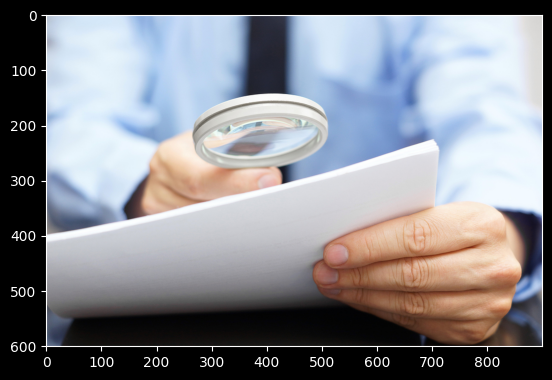

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
banner_image_url = "https://staticx-tuner.zacks.com/images/default_article_images/default341.jpg"
response = requests.get(banner_image_url)

if response.status_code == 200:
    img = mpimg.imread(BytesIO(response.content), format='JPG')
    imgplot = plt.imshow(img)
    plt.show()
else:
    print(f"Failed to retrieve the image. Status code: {response.status_code}")

### Set up the huggingface transformer

In [30]:
!pip list | grep pyarrow

pyarrow                       12.0.1


In [31]:
transformers_version = "v.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

print(f"Setting up everything with transformers version {transformers_version}")

%pip install huggingface_hub>=0.14.1 git+https://github.com/huggingface/transformers@$transformers_version pyarrow==12.0.1 diffusers==0.30.0 accelerate==0.33.0 datasets==2.15.0 torch==2.1.0 soundfile==0.12.1 sentencepiece==0.2.0 opencv-contrib-python-headless==4.8.1.78

Setting up everything with transformers version v4.29.0
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-8awj3kot
  Running command git checkout -q e9da9da8f64670e366fb6eaaa293ea97429f7aab


In [32]:
import IPython
import soundfile as sf

def play_audio(audio):
    sf.write("speech_converted.wav", audio.numpy(), samplerate=16000)
    return IPython.display.Audio("speech_converted.wav")

from huggingface_hub import notebook_login
notebook_login()

In [33]:
agent_name = "StarCoder (HF Token)" #@param ["StarCoder (HF Token)", "OpenAssistant (HF Token)", "OpenAI (API Key)"]

if agent_name == "StarCoder (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
    print("StarCoder is initialized 💪")

elif agent_name == "OpenAssistant (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent(url_endpoint="https://api-inference.huggingface.co/models/OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")
    print("OpenAssistant is initialized 💪")

elif agent_name == "OpenAI (API Key)":
    from transformers.tools import OpenAiAgent
    pswd = openai_apikey
    agent = OpenAiAgent(model="gpt-3.5-turbo", api_key=pswd)
    print("OpenAI is initialized 💪")

StarCoder is initialized 💪


In [34]:
caption = agent.run("Can you caption the `image`?", image=img)

==Explanation from the agent==
I will use the following  tool: `image_captioner` to generate a caption for the image.


==Code generated by the agent==
caption = image_captioner(image)
print(f"The caption is {caption}.")


==Result==


/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [35]:
data = {
  "text": caption,
  "model_id": "eleven_monolingual_v1",
  "voice_settings": {
    "stability": 0.5,
    "similarity_boost": 0.5
  }
}

response = requests.post(url, json=data, headers=headers)
with open('output.mp3', 'wb') as f:
    for chunk in response.iter_content(chunk_size=CHUNK_SIZE):
        if chunk:
            f.write(chunk)

audio_file = 'output.mp3'

audio = Audio(filename=audio_file, autoplay =True)
display(audio)

<a name="conclusion"></a>
- [Back to Contents](#contents)
## Conclusion

- Handle transactional and analytical queries with your vector data
- no need to export data out of SingleStore to another vector db
- Scan vectors fast with exact nearest neighbor. (DOT_PRODUCT, EUCLIDEAN_DISTANCE, and VECTOR_SUB are high-perf functions using single-instruction-multiple-data (SIMD) processor instructions)
- Ability to stream data directly into SingleStore
- Use SingleStore as Semantic Cache Layer leveraging the Plancache. No need for a cache layer.
- Easily scale the workspace for your workload
- handle reads and writes in parallel
- Use of external functions.

## Reset Demo

In [36]:
%%sql
DROP DATABASE llm_webinar;

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>